While CSV is simple and the most widely used data format (Excel, Google Sheets), there are several distinct advantages for Parquet, including:

* Parquet is column oriented and CSV is row oriented. Row-oriented formats are optimized for OLTP workloads while column-oriented formats are better suited for analytical workloads.
* Column-oriented databases such as AWS Redshift Spectrum bill by the amount data scanned per query
* Therefore, converting CSV to Parquet with partitioning and compression lowers overall costs and improves performance

In [1]:
#import os
#
#os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
#os.environ["MODIN_ENGINE"] = "dask"  # Modin will use Dask
#
#os.environ["MODIN_ENGINE"] = "unidist" # Modin will use Unidist
#os.environ["UNIDIST_BACKEND"] = "mpi" # Unidist will use MPI backend
#
#import modin.pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numba as nb
# Read the parquet file into a pandas dataframe
df = pd.read_parquet('SnowStorageDATA.parquet')
df

,YEAR,MO,DY,HR,PRECTOTCORR,Unnamed: 5,time,temperature_2m (°C),YEAR.1,MO.1,DY.1,HR.1,ALLSKY_SFC_SW_DWN,time.1,wind_speed_10m (km/h),Unnamed: 15,time.2,relative_humidity_2m (%)
0,2023,1,1,0,0.06,0.00006,2023-01-01T00:00,5.4,2023.0,1.0,1.0,0.0,0.0,2023-01-01T00:00,25.6,7.1,2023-01-01T00:00,91
1,2023,1,1,1,0.03,0.00003,2023-01-01T01:00,5.2,2023.0,1.0,1.0,1.0,0.0,2023-01-01T01:00,24.1,6.7,2023-01-01T01:00,91
2,2023,1,1,2,0.02,0.00002,2023-01-01T02:00,5.1,2023.0,1.0,1.0,2.0,0.0,2023-01-01T02:00,24.8,6.9,2023-01-01T02:00,90
3,2023,1,1,3,0.01,0.00001,2023-01-01T03:00,4.8,2023.0,1.0,1.0,3.0,0.0,2023-01-01T03:00,23.8,6.6,2023-01-01T03:00,90
4,2023,1,1,4,0.01,0.00001,2023-01-01T04:00,4.4,2023.0,1.0,1.0,4.0,0.0,2023-01-01T04:00,23.4,6.5,2023-01-01T04:00,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2023,12,31,19,0.00,0.00000,2023-12-31T19:00,-5.6,NaN,NaN,NaN,NaN,NaN,2023-12-31T19:00,12.6,3.5,2023-12-31T19:00,80
8756,2023,12,31,20,0.00,0.00000,2023-12-31T20:00,-5.3,NaN,NaN,NaN,NaN,NaN,2023-12-31T20:00,11.2,3.1,2023-12-31T20:00,79
8757,2023,12,31,21,0.01,0.00001,2023-12-31T21:00,-5.6,NaN,NaN,NaN,NaN,NaN,2023-12-31T21:00,9.7,2.7,2023-12-31T21:00,80
8758,2023,12,31,22,0.02,0.00002,2023-12-31T22:00,-6.3,NaN,NaN,NaN,NaN,NaN,2023-12-31T22:00,6.8,1.9,2023-12-31T22:00,84


In [2]:
# Find the index where the first NaN value appears in the 'YEAR.1' column
first_nan_index = df['YEAR.1'].isna().idxmax()
first_nan_index

8736

In [3]:
# Drop all rows after the first NaN value in the 'YEAR.1' column
df_wo_nan = df.loc[:first_nan_index-1]
df_wo_nan

,YEAR,MO,DY,HR,PRECTOTCORR,Unnamed: 5,time,temperature_2m (°C),YEAR.1,MO.1,DY.1,HR.1,ALLSKY_SFC_SW_DWN,time.1,wind_speed_10m (km/h),Unnamed: 15,time.2,relative_humidity_2m (%)
0,2023,1,1,0,0.06,0.00006,2023-01-01T00:00,5.4,2023.0,1.0,1.0,0.0,0.0,2023-01-01T00:00,25.6,7.1,2023-01-01T00:00,91
1,2023,1,1,1,0.03,0.00003,2023-01-01T01:00,5.2,2023.0,1.0,1.0,1.0,0.0,2023-01-01T01:00,24.1,6.7,2023-01-01T01:00,91
2,2023,1,1,2,0.02,0.00002,2023-01-01T02:00,5.1,2023.0,1.0,1.0,2.0,0.0,2023-01-01T02:00,24.8,6.9,2023-01-01T02:00,90
3,2023,1,1,3,0.01,0.00001,2023-01-01T03:00,4.8,2023.0,1.0,1.0,3.0,0.0,2023-01-01T03:00,23.8,6.6,2023-01-01T03:00,90
4,2023,1,1,4,0.01,0.00001,2023-01-01T04:00,4.4,2023.0,1.0,1.0,4.0,0.0,2023-01-01T04:00,23.4,6.5,2023-01-01T04:00,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8731,2023,12,30,19,0.11,0.00011,2023-12-30T19:00,0.0,2023.0,12.0,30.0,19.0,0.0,2023-12-30T19:00,25.2,7.0,2023-12-30T19:00,89
8732,2023,12,30,20,0.09,0.00009,2023-12-30T20:00,-0.4,2023.0,12.0,30.0,20.0,0.0,2023-12-30T20:00,25.9,7.2,2023-12-30T20:00,86
8733,2023,12,30,21,0.08,0.00008,2023-12-30T21:00,-0.8,2023.0,12.0,30.0,21.0,0.0,2023-12-30T21:00,23.8,6.6,2023-12-30T21:00,85
8734,2023,12,30,22,0.07,0.00007,2023-12-30T22:00,-1.0,2023.0,12.0,30.0,22.0,0.0,2023-12-30T22:00,23.4,6.5,2023-12-30T22:00,84


In [4]:
# Find the index where 'time.1' starts at '2023-04-01T00:00'
period_start_in = df[df['time.1'] == '2023-04-01T00:00'].index[0]

# Find the index where 'time.1' ends at '2023-05-01T00:00' (example stop period)
period_end_in = df[df['time.1'] == '2023-08-31T23:00'].index[0]

# Slice the DataFrame to include only the desired period
df_wo_nan_period = df_wo_nan.loc[period_start_in:period_end_in]

df_wo_nan_period

,YEAR,MO,DY,HR,PRECTOTCORR,Unnamed: 5,time,temperature_2m (°C),YEAR.1,MO.1,DY.1,HR.1,ALLSKY_SFC_SW_DWN,time.1,wind_speed_10m (km/h),Unnamed: 15,time.2,relative_humidity_2m (%)
2160,2023,4,1,0,0.00,0.00000,2023-04-01T00:00,0.2,2023.0,4.0,1.0,0.0,0.00,2023-04-01T00:00,21.6,6.0,2023-04-01T00:00,72
2161,2023,4,1,1,0.01,0.00001,2023-04-01T01:00,0.1,2023.0,4.0,1.0,1.0,0.00,2023-04-01T01:00,22.0,6.1,2023-04-01T01:00,75
2162,2023,4,1,2,0.01,0.00001,2023-04-01T02:00,-0.1,2023.0,4.0,1.0,2.0,0.00,2023-04-01T02:00,23.4,6.5,2023-04-01T02:00,65
2163,2023,4,1,3,0.01,0.00001,2023-04-01T03:00,-0.2,2023.0,4.0,1.0,3.0,0.00,2023-04-01T03:00,23.4,6.5,2023-04-01T03:00,77
2164,2023,4,1,4,0.00,0.00000,2023-04-01T04:00,-0.4,2023.0,4.0,1.0,4.0,34.09,2023-04-01T04:00,25.2,7.0,2023-04-01T04:00,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5827,2023,8,31,19,0.00,0.00000,2023-08-31T19:00,17.5,2023.0,8.0,31.0,19.0,0.00,2023-08-31T19:00,14.4,4.0,2023-08-31T19:00,86
5828,2023,8,31,20,0.00,0.00000,2023-08-31T20:00,17.1,2023.0,8.0,31.0,20.0,0.00,2023-08-31T20:00,14.8,4.1,2023-08-31T20:00,88
5829,2023,8,31,21,0.00,0.00000,2023-08-31T21:00,16.9,2023.0,8.0,31.0,21.0,0.00,2023-08-31T21:00,13.7,3.8,2023-08-31T21:00,91
5830,2023,8,31,22,0.01,0.00001,2023-08-31T22:00,16.5,2023.0,8.0,31.0,22.0,0.00,2023-08-31T22:00,13.0,3.6,2023-08-31T22:00,91


In [5]:
# Reset indecies for new dataframe
df_wo_nan_period_reset = df_wo_nan_period.reset_index(drop=True)
df_wo_nan_period_reset

,YEAR,MO,DY,HR,PRECTOTCORR,Unnamed: 5,time,temperature_2m (°C),YEAR.1,MO.1,DY.1,HR.1,ALLSKY_SFC_SW_DWN,time.1,wind_speed_10m (km/h),Unnamed: 15,time.2,relative_humidity_2m (%)
0,2023,4,1,0,0.00,0.00000,2023-04-01T00:00,0.2,2023.0,4.0,1.0,0.0,0.00,2023-04-01T00:00,21.6,6.0,2023-04-01T00:00,72
1,2023,4,1,1,0.01,0.00001,2023-04-01T01:00,0.1,2023.0,4.0,1.0,1.0,0.00,2023-04-01T01:00,22.0,6.1,2023-04-01T01:00,75
2,2023,4,1,2,0.01,0.00001,2023-04-01T02:00,-0.1,2023.0,4.0,1.0,2.0,0.00,2023-04-01T02:00,23.4,6.5,2023-04-01T02:00,65
3,2023,4,1,3,0.01,0.00001,2023-04-01T03:00,-0.2,2023.0,4.0,1.0,3.0,0.00,2023-04-01T03:00,23.4,6.5,2023-04-01T03:00,77
4,2023,4,1,4,0.00,0.00000,2023-04-01T04:00,-0.4,2023.0,4.0,1.0,4.0,34.09,2023-04-01T04:00,25.2,7.0,2023-04-01T04:00,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3667,2023,8,31,19,0.00,0.00000,2023-08-31T19:00,17.5,2023.0,8.0,31.0,19.0,0.00,2023-08-31T19:00,14.4,4.0,2023-08-31T19:00,86
3668,2023,8,31,20,0.00,0.00000,2023-08-31T20:00,17.1,2023.0,8.0,31.0,20.0,0.00,2023-08-31T20:00,14.8,4.1,2023-08-31T20:00,88
3669,2023,8,31,21,0.00,0.00000,2023-08-31T21:00,16.9,2023.0,8.0,31.0,21.0,0.00,2023-08-31T21:00,13.7,3.8,2023-08-31T21:00,91
3670,2023,8,31,22,0.01,0.00001,2023-08-31T22:00,16.5,2023.0,8.0,31.0,22.0,0.00,2023-08-31T22:00,13.0,3.6,2023-08-31T22:00,91


In [6]:
# Extract the air velocity column from the dataframe
df_air_vel = df_wo_nan_period_reset.iloc[:, 15]
df_air_vel

0       6.0
1       6.1
2       6.5
3       6.5
4       7.0
       ... 
3667    4.0
3668    4.1
3669    3.8
3670    3.6
3671    2.8
Name: Unnamed: 15, Length: 3672, dtype: float64

In [7]:
# Extract the air temperature column from the dataframe
df_air_temp = df_wo_nan_period_reset.iloc[:, 7]
df_air_temp

0        0.2
1        0.1
2       -0.1
3       -0.2
4       -0.4
        ... 
3667    17.5
3668    17.1
3669    16.9
3670    16.5
3671    15.8
Name: temperature_2m (°C), Length: 3672, dtype: float64

Precipitation is any form of water that falls from the atmosphere to the Earth's surface. It includes various types of weather phenomena, such as:

- **Rain**: Liquid water droplets that fall when the air temperature is above freezing.
- **Snow**: Ice crystals that form when the air temperature is below freezing.
- **Sleet**: Small ice pellets that form when raindrops freeze before hitting the ground.
- **Hail**: Larger ice pellets that form in strong thunderstorms with intense updrafts.
- **Drizzle**: Light rain with very small water droplets.
- **Freezing Rain**: Rain that freezes upon contact with cold surfaces, forming a layer of ice.

In [8]:
# Extract the amount of precipitation column from the dataframe
df_am_of_perc = df_wo_nan_period_reset.iloc[:, 5] # m/h
df_am_of_perc

0       0.00000
1       0.00001
2       0.00001
3       0.00001
4       0.00000
         ...   
3667    0.00000
3668    0.00000
3669    0.00000
3670    0.00001
3671    0.00001
Name: Unnamed: 5, Length: 3672, dtype: float64

---
$$
Q_{ground} = \lambda_{ground} A_{ground} \frac{\Delta T_g}{l}
$$

In [9]:
lam = 1.0 # W/(mK); thermal conductivity of the ground
A_ground = 210.0 # m^2; area of the ground
T1 = 0.0 # °C
T2 = 6.0 # °C
dT = T2 - T1
l = 1.0 # m; thickness of the ground
Q_ground = lam * A_ground * dT/l
print(f'The thermal heat energy from the ground is {Q_ground} W.')

The thermal heat energy from the ground is 1260.0 W.


---
$$Q_{melt} = \frac{Q_{ground}}{L_f \cdot \rho_{snow}}$$

In [10]:
L_f = 333.4E03 # J/kg; latent heat of fusion
rho_snow = 411.0 # kg/m^3; density of snow
# The rate of melted snow from ground melt
Q_melt = Q_ground/(L_f * rho_snow)
print(f'The rate of melted snow from ground melt is {Q_melt:.4e} m^3/s.')

The rate of melted snow from ground melt is 9.1952e-06 m^3/s.


---

In [11]:
# Total volume of melted snow due to ground melt
Q_melt_total = Q_melt * 3600 # m^3/h
print(f'The total hourly volume of melted snow due to ground melt is {Q_melt_total:.4f} m^3/h.')

The total hourly volume of melted snow due to ground melt is 0.0331 m^3/h.


In [12]:
df2 = pd.read_parquet('SurfaceMeltRateDATA.parquet')
df2

,G(h)_W/m2,Gb(n)_W/m2,Gd(h)_W/m2,IR(h)_W/m2,RH_%
0,0.00,0.0,0,306.98,72
1,0.00,0.0,0,311.56,75
2,0.00,0.0,0,316.14,65
3,0.00,0.0,0,320.72,77
4,34.09,0.0,0,325.31,78
...,...,...,...,...,...
3667,0.00,0.0,0,303.45,86
3668,0.00,0.0,0,308.59,88
3669,0.00,0.0,0,313.73,91
3670,0.00,0.0,0,318.88,91


Checking if the raw and snowmelt data are the same

In [13]:
# Relative humidity (%)
# Extract the columns to be compared
df_RH_temp = df_wo_nan_period.iloc[:, 17].reset_index(drop=True)
df2_RH = df2.iloc[:, 4].reset_index(drop=True)

# Determine the length of the shorter column
min_length = min(len(df_RH_temp), len(df2_RH))

# Compare the columns up to the length of the shorter column
not_equal_indices = df_RH_temp.iloc[:min_length] != df2_RH.iloc[:min_length]

# Display the rows and the values at each row where they are not equal
for index in not_equal_indices[not_equal_indices].index:
    print(f"Row {index}:")
    print(f"df_RH value: {df_RH_temp.iloc[index]}")
    print(f"df2 value: {df2_RH.iloc[index]}")
    print()

In [14]:
print(len(df_RH_temp))
print(len(df2_RH))

3672
3672


In [15]:
df_RH_temp

0       72
1       75
2       65
3       77
4       78
        ..
3667    86
3668    88
3669    91
3670    91
3671    93
Name: relative_humidity_2m (%), Length: 3672, dtype: int64

In [16]:
df2_RH

0       72
1       75
2       65
3       77
4       78
        ..
3667    86
3668    88
3669    91
3670    91
3671    93
Name: RH_%, Length: 3672, dtype: int64

In [17]:
# Globalr solar irradiance W/m2
df_Gsi = df_wo_nan_period_reset['ALLSKY_SFC_SW_DWN']
df_Gsi

0        0.00
1        0.00
2        0.00
3        0.00
4       34.09
        ...  
3667     0.00
3668     0.00
3669     0.00
3670     0.00
3671     0.00
Name: ALLSKY_SFC_SW_DWN, Length: 3672, dtype: float64

In [18]:
# Heat transfer coefficient at the external surface
h = 22.7 # W/(m^2K)
# Solar light absorptivity
alpha = 0.8
# Correction factor for horizontal surface
T_cor_fact = 4.0 # °C
df_T_sol_air =  alpha * df_Gsi / h + df_air_temp - T_cor_fact
df_T_sol_air

0       -3.80000
1       -3.90000
2       -4.10000
3       -4.20000
4       -3.19859
          ...   
3667    13.50000
3668    13.10000
3669    12.90000
3670    12.50000
3671    11.80000
Length: 3672, dtype: float64

---
$$
Q_{surface} = A_{surface} \cdot \frac{\lambda_i}{d} \cdot \Delta T_s
$$

In [19]:
# Insulation layer thickness
d_ins = 0.1 # m
# Thermal conductivity for the insulating material
lam_i = 0.32 # W/(mK)
# The surface area (m2) of the pile of snow
A_surf = 210.0 # m^2
# The rate of heat transfer from the snow pile to the air
df_Q = A_surf * lam_i / d_ins * (df_T_sol_air - 0.0)    # W
df_Q

0      -2553.600000
1      -2620.800000
2      -2755.200000
3      -2822.400000
4      -2149.452687
           ...     
3667    9072.000000
3668    8803.200000
3669    8668.800000
3670    8400.000000
3671    7929.600000
Length: 3672, dtype: float64

In [20]:
# Thermal diffusivity for the insulation
c_wet = 2.59E03 # J/(kg*K)
rho_dry = 100.0 # kg/m^3
moist_cont = 50.0 # %
rho_wet = rho_dry + moist_cont/100.0 * 1000 # kg/m^3
c_dry = 0.99E03 # J/(kg*K)
c_water = 4.19E03 # J/(kg * K)

c_wet = (1.0 - moist_cont/100.0)*c_dry + moist_cont/100.0*c_water
print(f"Specific heat capacity (wet): {c_wet/1000.0:.4} kJ/(kg*K).")

D = lam_i/(c_wet * rho_wet) # m^2/s
print(f"Thermal diffusivity of the insulating material is {D:.4e} m^2/s.")

Specific heat capacity (wet): 2.59 kJ/(kg*K).
Thermal diffusivity of the insulating material is 2.0592e-07 m^2/s.


In [21]:
# The rate of melted snow from surface melt
df_f_melt_surf = df_Q/(L_f * rho_snow) # m^3/s
# Print the Series in scientific notation
formatted_series = df_f_melt_surf.apply(lambda x: f'{x:.4e}')
print(formatted_series)

0       -1.8636e-05
1       -1.9126e-05
2       -2.0107e-05
3       -2.0597e-05
4       -1.5686e-05
           ...     
3667     6.6206e-05
3668     6.4244e-05
3669     6.3263e-05
3670     6.1302e-05
3671     5.7869e-05
Length: 3672, dtype: object


In [22]:
# Hourly rate of melted snow from surface melt
df_f_melt_surf_total = df_f_melt_surf * 3600 # m^3/h
#df_f_melt_surf_total.apply(lambda x: f'{x:.4f}')
df_f_melt_surf_total

0      -0.067088
1      -0.068854
2      -0.072385
3      -0.074150
4      -0.056471
          ...   
3667    0.238341
3668    0.231279
3669    0.227748
3670    0.220686
3671    0.208327
Length: 3672, dtype: float64

In [23]:
rho_water = 1000 # kg/m^3
# The heat flux from rain

# Initialize the Series with zeros
df_q_rain = pd.Series(0.0, index=df_air_temp.index)  # Initialize with float zeros

# Create a mask where air temperature is greater than 0
positive_temp_mask = df_air_temp > 0

# Calculate the heat flux where the air temperature is greater than 0
df_q_rain[positive_temp_mask] = df_am_of_perc[positive_temp_mask] * rho_water * c_water * df_air_temp[positive_temp_mask] / 3600.0

df_q_rain

0       0.000000
1       0.001164
2       0.000000
3       0.000000
4       0.000000
          ...   
3667    0.000000
3668    0.000000
3669    0.000000
3670    0.192042
3671    0.183894
Length: 3672, dtype: float64

---
$$
v_{rain} = \frac{P A_{surf} \rho_{water} c_{water} T_{surroundings}}{L_{snow} \rho_{snow}}
$$

$P$ - percipitation

In [24]:
print(df_am_of_perc)
print(A_surf)
print(rho_water)
print(c_water)
print(df_air_temp)
print(L_f)
print(rho_snow)

0       0.00000
1       0.00001
2       0.00001
3       0.00001
4       0.00000
         ...   
3667    0.00000
3668    0.00000
3669    0.00000
3670    0.00001
3671    0.00001
Name: Unnamed: 5, Length: 3672, dtype: float64
210.0
1000
4190.0
0        0.2
1        0.1
2       -0.1
3       -0.2
4       -0.4
        ... 
3667    17.5
3668    17.1
3669    16.9
3670    16.5
3671    15.8
Name: temperature_2m (°C), Length: 3672, dtype: float64
333400.0
411.0


[?]

In [25]:
# How much rainwater can be generated from melting snow under given conditions?
# Volume of rainwater produced per hour?
df_v_rain = df_am_of_perc * A_surf * rho_water * c_water * df_air_temp / (L_f * rho_snow) # m^3/h
df_v_rain.apply(lambda x: f'{x:.4e}')

0        0.0000e+00
1        6.4213e-06
2       -6.4213e-06
3       -1.2843e-05
4       -0.0000e+00
           ...     
3667     0.0000e+00
3668     0.0000e+00
3669     0.0000e+00
3670     1.0595e-03
3671     1.0146e-03
Length: 3672, dtype: object

[?]

In [26]:
# Initialize the Series with zeros for SMR
df_SMR_temp = pd.Series(0.0, index=df_air_temp.index)  # Initialize with float zeros

# Create a mask where air temperature is greater than 0
smr_temp_mask = df_air_temp > 0.0

# Calculate the surface melt rate where the temperature is greater than 0
df_SMR_temp[smr_temp_mask] = df_f_melt_surf_total[smr_temp_mask] * rho_snow / A_surf # kg/(m^2*h)
# The mass flux of melted snow per unit area per hour due to temperatures above 0°C?
df_SMR_temp


0      -0.131302
1      -0.134757
2       0.000000
3       0.000000
4       0.000000
          ...   
3667    0.466467
3668    0.452645
3669    0.445735
3670    0.431914
3671    0.407726
Length: 3672, dtype: float64

[?]

In [27]:
# The mass flux of snow melted per unit area per hour from rain?
df_SMR_rain = df_v_rain * rho_snow / A_surf # kg/(m^2*h)
df_SMR_rain

0       0.000000
1       0.000013
2      -0.000013
3      -0.000025
4      -0.000000
          ...   
3667    0.000000
3668    0.000000
3669    0.000000
3670    0.002074
3671    0.001986
Length: 3672, dtype: float64

In [28]:
df_SMR_total = df_SMR_temp + df_SMR_rain
df_SMR_total

0      -0.131302
1      -0.134744
2      -0.000013
3      -0.000025
4       0.000000
          ...   
3667    0.466467
3668    0.452645
3669    0.445735
3670    0.433987
3671    0.409712
Length: 3672, dtype: float64

In [29]:
# Cumulative sum of the total surface melt rate
df_SMR_total_rain_cs = df_SMR_total.cumsum()
df_SMR_total_rain_cs

0         -0.131302
1         -0.266046
2         -0.266059
3         -0.266084
4         -0.266084
           ...     
3667    2438.426695
3668    2438.879340
3669    2439.325075
3670    2439.759062
3671    2440.168774
Length: 3672, dtype: float64

---
$$
SMR = -0.09 + 0.00014 \cdot P_{solar} + 0.0575 \cdot T_{air} + 0.0012 \cdot T_{air} \cdot u_{air} - 0.18 \cdot T_{air} \cdot Z
$$

In [30]:
df_P_solar = df_Gsi
# Surface melt rate from solar radiation, air temperature, air velocity and insulation thickness
df_SMR_emp1 = -0.09 + 0.00014 * df_P_solar + 0.0575*df_air_temp + 0.0012*df_air_temp*df_air_vel - 0.18*df_air_temp*d_ins # kg/m2/h
df_SMR_emp1 # Empirical model 1

0      -0.080660
1      -0.085318
2      -0.094730
3      -0.099460
4      -0.104387
          ...   
3667    0.685250
3668    0.669582
3669    0.654614
3670    0.633030
3671    0.587188
Length: 3672, dtype: float64

In [31]:
def Psat_WV(T_K):
    """
    Water vapour saturation pressure
    W. Wagner and A. Pruß:" The IAPWS Formulation 1995 for the
    Thermodynamic Properties of Ordinary Water Substance for General and Scientific Use ",
    Journal of Physical and Chemical Reference Data, June 2002 ,Volume 31, Issue 2, pp.
    387535)

    Returns Saturation vapor pressure (hPa)
    """
    Tc = 647.096  # Critical temperature, K
    Pc = 220640   # Critical pressure, hPa
    
    C1 = -7.85951783
    C2 = 1.84408259
    C3 = -11.7866497
    C4 = 22.6807411
    C5 = -15.9618719
    C6 = 1.80122502
    
    teta = 1 - T_K / Tc
    
    x = Tc / T_K * (C1 * teta + C2 * teta ** 1.5 + C3 * teta ** 3 + C4 * teta ** 3.5 + C5 * teta ** 4 + C6 * teta ** 7.5)
    
    x = np.exp(x) * Pc
    
    return x

# Example usage:
#T_K = 300  # Example temperature in Kelvin
#print(f"Saturation vapor pressure at {T_K} K is {Psat_WV(T_K)} hPa")

In [32]:
#%%timeit
# Calculate the saturation vapor pressure at the air temperature
df_Psat = Psat_WV(df_air_temp + 273.15)/10.0 # hPa; 100/1000 to convert to hPa
df_Psat

0       0.620152
1       0.615668
2       0.606786
3       0.602388
4       0.593677
          ...   
3667    2.000549
3668    1.950561
3669    1.925980
3670    1.877632
3671    1.795581
Name: temperature_2m (°C), Length: 3672, dtype: float64

In [33]:
# Get the relative humidity of percipitation
df_RH_perc = df_wo_nan_period_reset.iloc[:, 17]
df_RH_perc

0       72
1       75
2       65
3       77
4       78
        ..
3667    86
3668    88
3669    91
3670    91
3671    93
Name: relative_humidity_2m (%), Length: 3672, dtype: int64

In [34]:
df_Psat

0       0.620152
1       0.615668
2       0.606786
3       0.602388
4       0.593677
          ...   
3667    2.000549
3668    1.950561
3669    1.925980
3670    1.877632
3671    1.795581
Name: temperature_2m (°C), Length: 3672, dtype: float64

In [35]:
# Water steam pressure
df_Pw = df_Psat*df_RH_perc/100.0 # kPa
df_Pw

0       0.446509
1       0.461751
2       0.394411
3       0.463839
4       0.463068
          ...   
3667    1.720472
3668    1.716493
3669    1.752642
3670    1.708645
3671    1.669890
Length: 3672, dtype: float64

In [36]:
# Absolute humidity
df_w = 2.16679*df_Pw*1000/(273.15+df_air_temp) # g/m^3; 1000 to convert to kPa
df_w

0        3.539389
1        3.661546
2        3.129852
3        3.682145
4        3.678720
          ...    
3667    12.826084
3668    12.814059
3669    13.092937
3670    12.781892
3671    12.522243
Length: 3672, dtype: float64

In [37]:
def Psat_WV_vectorized(T_K):
    """
    Water vapour saturation pressure
    W. Wagner and A. Pruß:" The IAPWS Formulation 1995 for the
    Thermodynamic Properties of Ordinary Water Substance for General and Scientific Use ",
    Journal of Physical and Chemical Reference Data, June 2002 ,Volume 31, Issue 2, pp.
    387535)

    Returns Saturation vapor pressure (hPa)
    """
    Tc = 647.096  # Critical temperature, K
    Pc = 220640   # Critical pressure, hPa
    
    C1 = -7.85951783
    C2 = 1.84408259
    C3 = -11.7866497
    C4 = 22.6807411
    C5 = -15.9618719
    C6 = 1.80122502
    
    teta = 1 - T_K / Tc
    
    x = Tc / T_K * (C1 * teta + C2 * np.power(teta, 1.5) + C3 * np.power(teta, 3) + C4 * np.power(teta, 3.5) + C5 * np.power(teta, 4) + C6 * np.power(teta, 7.5))
    
    x = np.exp(x) * Pc
    
    return x

# Example usage with a pandas DataFrame
#data = {'Temperature_K': [300, 310, 320, 330, 340]}  # Example temperatures in Kelvin
#df = pd.DataFrame(data)
#df['Saturation_Vapor_Pressure_hPa'] = Psat_WV_vectorized(df['Temperature_K'])
#print(df)

In [38]:
#%%timeit
df_Psat_vec = Psat_WV_vectorized(df_air_temp + 273.15) # hPa
df_Psat_vec

0        6.201519
1        6.156680
2        6.067863
3        6.023882
4        5.936768
          ...    
3667    20.005488
3668    19.505606
3669    19.259798
3670    18.776320
3671    17.955812
Name: temperature_2m (°C), Length: 3672, dtype: float64

---
## Wood chips as thermal insulation of snow
https://doi.org/10.1016/j.coldregions.2005.06.001

$$
SMR = -0.97 - 0.097 \cdot Z + 0.164 \cdot u_{air} + 0.00175 \cdot i_{light} + 0.102 \cdot T_{air} + 0.192 \cdot AH
$$

In [39]:
#print(d_ins)
#print(df_air_temp)
#print(df_Gsi)
#print(df_air_temp)
print(df_w)

0        3.539389
1        3.661546
2        3.129852
3        3.682145
4        3.678720
          ...    
3667    12.826084
3668    12.814059
3669    13.092937
3670    12.781892
3671    12.522243
Length: 3672, dtype: float64


In [40]:
df_air_vel[1:2]

1    6.1
Name: Unnamed: 15, dtype: float64

In [41]:
# Some weird rounding error?
#-0.97-0.097*(d_ins*100)+0.164*df_air_vel+0.00175*df_Gsi+0.102*(df_air_temp)+0.192*df_w
-0.97 - 0.097*0.1*100 + 0.164*6.1 + 0.00175*0.0 + 0.102*0.1 + 0.192*3.661546


-0.22638316800000002

---
## Wood chips as thermal insulation of snow
https://doi.org/10.1016/j.coldregions.2005.06.001

$$
SMR = -0.97 - 0.097 \cdot Z + 0.164 \cdot u_{air} + 0.00175 \cdot i_{light} + 0.102 \cdot T_{air} + 0.192 \cdot AH
$$

In [42]:
# Surface melt rate from insulation thickness, air velocity, light intensity, air temperature and air humidity
df_SMR_emp2 = -0.97 - 0.097*(d_ins*100) + 0.164*df_air_vel + 0.00175*df_Gsi + 0.102*df_air_temp + 0.192*df_w # kg/m2/h
df_SMR_emp2 # Empirical model 2

0      -0.256037
1      -0.226383
2      -0.283268
3      -0.187428
4      -0.066828
          ...   
3667    2.963608
3668    2.936899
3669    2.920844
3670    2.787523
3671    2.535071
Length: 3672, dtype: float64

In [43]:
#%%timeit
# Fastest method
# Applying the condition using the np.where() function and storing the result in a new Series object
df_SMR_emp1_cond = pd.Series(np.where((df_SMR_emp1 < 0) | (df_air_temp < 0), 0, df_SMR_emp1))
df_SMR_emp1_cond

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
3667    0.685250
3668    0.669582
3669    0.654614
3670    0.633030
3671    0.587188
Length: 3672, dtype: float64

In [44]:
#%%timeit
## Applying the condition using mask
#df_SMR_emp1_cond = df_SMR_emp1.mask((df_SMR_emp1 < 0) | (df_air_temp < 0), 0)
#df_SMR_emp1_cond

In [45]:
#%%timeit
## Applying the condition
#df_SMR_emp1_cond = df_SMR_emp1.where((df_SMR_emp1 >= 0) & (df_air_temp >= 0), 0)
#df_SMR_emp1_cond

In [46]:
df_SMR_emp2

0      -0.256037
1      -0.226383
2      -0.283268
3      -0.187428
4      -0.066828
          ...   
3667    2.963608
3668    2.936899
3669    2.920844
3670    2.787523
3671    2.535071
Length: 3672, dtype: float64

This condition ensures that any negative values in df_SMR_emp2 or any values when the air temperature is below freezing are replaced with 0. Most likely to avoid unrealistic or invalid data, as negative melt rates or melt rates at sub-zero temperatures don't make physical sense.

In [47]:
# If df_SMR_emp2 is less than 0 or df_air_temp is less than 0, the value is set to 0.
# Otherwise, it keeps the original value from df_SMR_emp2.
df_SMR_emp2_cond = pd.Series(np.where((df_SMR_emp2 < 0) | (df_air_temp < 0), 0, df_SMR_emp2))
df_SMR_emp2_cond

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
3667    2.963608
3668    2.936899
3669    2.920844
3670    2.787523
3671    2.535071
Length: 3672, dtype: float64

In [48]:
df_SMR_emp1_cond_cs = df_SMR_emp1_cond.cumsum()
df_SMR_emp2_cond_cs = df_SMR_emp2_cond.cumsum()
display(df_SMR_emp1_cond_cs)
display(df_SMR_emp2_cond_cs)

0          0.000000
1          0.000000
2          0.000000
3          0.000000
4          0.000000
           ...     
3667    2213.013906
3668    2213.683488
3669    2214.338102
3670    2214.971132
3671    2215.558320
Length: 3672, dtype: float64

0          0.000000
1          0.000000
2          0.000000
3          0.000000
4          0.000000
           ...     
3667    8181.811551
3668    8184.748450
3669    8187.669294
3670    8190.456817
3671    8192.991888
Length: 3672, dtype: float64

In [49]:
#def transient_1d():


In [50]:
"""def transient_1d():
    # Load the Excel file
    file_path = "SnowStorage.xlsm"
    model_sheet = pd.read_excel(file_path, sheet_name="model", engine="openpyxl")

    # Extract necessary values from the Excel sheet
    delta_db = model_sheet.loc[11, 'Ao']  # Layer thickness, m
    k_db = model_sheet.loc[13, 'Ao']  # Thermal conductivity
    a_db = model_sheet.loc[14, 'Ao']  # Thermal diffusivity
    dx = model_sheet.loc[20, 'Ao']  # Cell size, m
    dt = model_sheet.loc[19, 'Ao']  # Time interval
    h_i = model_sheet.loc[22, 'Ao']  # Heat transfer coefficient at inner surface, W/m2K

    t_o_range = model_sheet.loc[27:3698, 'al']  # Input range with air temperature

    n_el = int(delta_db / dx)  # Number of numerical elements
    nr_hour = len(t_o_range)  # Number of hours
    nodes = n_el + 1  # Number of nodes

    # Initialize arrays
    T_n = np.zeros(nodes)
    T_nh = np.zeros((nodes, nr_hour))
    dFo = np.zeros(nr_hour)
    dBio_i = np.zeros(nr_hour)
    dBio_o = np.zeros(nr_hour)
    h_o = np.zeros(nr_hour)
    t_o = np.zeros(nr_hour)

    for i in range(nr_hour):
        t_o[i] = t_o_range.iloc[i]
        h_o[i] = model_sheet.iloc[i + 27, model_sheet.columns.get_loc('al') - 1]

    nh = int(3600 / dt)  # Number of time intervals in one hour

    for h in range(nr_hour):
        dFo[h] = a_db * dt / dx
        dBio_i[h] = h_i * dx / k_db
        dBio_o[h] = h_o[h] * dx / k_db

        for k in range(nh):
            a = np.zeros(nodes)
            b = np.zeros(nodes)
            c = np.zeros(nodes)
            d = np.zeros(nodes)

            b[0] = (1 + 2 * dFo[h] + 2 * dFo[h] * dBio_o[h])
            c[0] = -2 * dFo[h]
            d[0] = T_n[0] + 2 * dFo[h] * dBio_o[h] * t_o[h]

            for j in range(1, nodes - 1):
                a[j] = -dFo[h]
                b[j] = (1 + 2 * dFo[h])
                c[j] = -dFo[h]
                d[j] = T_n[j]

            a[nodes - 1] = -2 * dFo[h]
            b[nodes - 1] = (1 + 2 * dFo[h] + 2 * dFo[h] * dBio_i[h])
            d[nodes - 1] = T_n[nodes - 1] + 2 * dFo[h] * dBio_i[h]

            T_n = solve_tdma(a, b, c, d, nodes)

        for j in range(nodes):
            T_nh[j, h] = T_n[j]

    for h in range(nr_hour):
        model_sheet.iloc[h + 27, model_sheet.columns.get_loc('al') + 1] = T_nh[nodes - 1, h]
        model_sheet.iloc[h + 27, model_sheet.columns.get_loc('al') + 2] = T_nh[0, h]

def solve_tdma(a, b, c, d, n):
    c_prime = np.zeros(n)
    d_prime = np.zeros(n)
    x = np.zeros(n)

    c_prime[0] = c[0] / b[0]
    d_prime[0] = d[0] / b[0]

    for i in range(1, n):
        c_prime[i] = c[i] / (b[i] - a[i] * c_prime[i - 1])
        d_prime[i] = (d[i] - a[i] * d_prime[i - 1]) / (b[i] - a[i] * c_prime[i - 1])

    x[n - 1] = d_prime[n - 1]

    for i in range(n - 2, -1, -1):
        x[i] = d_prime[i] - c_prime[i] * x[i + 1]

    return x

# Run the function
transient_1d()"""

'def transient_1d():\n    # Load the Excel file\n    file_path = "SnowStorage.xlsm"\n    model_sheet = pd.read_excel(file_path, sheet_name="model", engine="openpyxl")\n\n    # Extract necessary values from the Excel sheet\n    delta_db = model_sheet.loc[11, \'Ao\']  # Layer thickness, m\n    k_db = model_sheet.loc[13, \'Ao\']  # Thermal conductivity\n    a_db = model_sheet.loc[14, \'Ao\']  # Thermal diffusivity\n    dx = model_sheet.loc[20, \'Ao\']  # Cell size, m\n    dt = model_sheet.loc[19, \'Ao\']  # Time interval\n    h_i = model_sheet.loc[22, \'Ao\']  # Heat transfer coefficient at inner surface, W/m2K\n\n    t_o_range = model_sheet.loc[27:3698, \'al\']  # Input range with air temperature\n\n    n_el = int(delta_db / dx)  # Number of numerical elements\n    nr_hour = len(t_o_range)  # Number of hours\n    nodes = n_el + 1  # Number of nodes\n\n    # Initialize arrays\n    T_n = np.zeros(nodes)\n    T_nh = np.zeros((nodes, nr_hour))\n    dFo = np.zeros(nr_hour)\n    dBio_i = np.ze

In [51]:
df3 = pd.read_parquet('TsiTsoDATA.parquet')
df3

,Tsi_C,Tso_C
0,-1.211547e-35,-0.422381
1,-1.349124e-29,-0.715959
2,-4.325687e-26,-0.960885
3,-1.230188e-23,-1.149471
4,-9.227676e-22,-1.188722
...,...,...
3667,6.614035e-01,15.125034
3668,6.612097e-01,14.919390
3669,6.610148e-01,14.754398
3670,6.608188e-01,14.597013


[?]

In [52]:
#df_Tsi = df3['Tsi_C']
#df_Tsi

In [53]:
#df_Tso = df3['Tso_C']
#df_Tso

In [54]:
df_air_vel

0       6.0
1       6.1
2       6.5
3       6.5
4       7.0
       ... 
3667    4.0
3668    4.1
3669    3.8
3670    3.6
3671    2.8
Name: Unnamed: 15, Length: 3672, dtype: float64

In [55]:
# Some floating point arithmetic hooliganism happening again
7.41 * (6.11111111111**0.78)

30.408286498835363

[?]

In [56]:
# Air velocity with conditions
df_ho = pd.Series(
    np.where(
        df_air_vel <= 5.0,
        6.0 + 4.0*df_air_vel,
        7.41 * (df_air_vel**0.78)
    )
)

df_ho # m/s

0       29.976173
1       30.365153
2       31.907342
3       31.907342
4       33.806069
          ...    
3667    22.000000
3668    22.400000
3669    21.200000
3670    20.400000
3671    17.200000
Length: 3672, dtype: float64

In [57]:
"""def transient_1d():
    # Load data from Excel or other sources
    # For simplicity, we'll assume the data is already loaded into variables
    delta_db = 0.1  # Layer thickness, m
    k_db = 1.0      # Thermal conductivity
    a_db = 1.0      # Thermal diffusivity
    dx = 0.01       # Cell size, m
    dt = 1.0        # Time interval
    h_i = 10.0      # Heat transfer coefficient at inner surface, W/m2K
    t_i = 0.0       # Inner temperature, C

    # Example temperature and heat transfer coefficient arrays
    t_o = np.array([20.0] * 3600)  # Temperature of air, C
    h_o = np.array([10.0] * 3600)  # Outer heat transfer coefficient, W/m2K

    n_el = int(delta_db / dx)  # Number of numerical elements
    nodes = n_el + 1           # Number of nodes

    # Initialize temperature distribution
    T_n = np.zeros(nodes)
    T_nh = np.zeros((nodes, len(t_o)))

    # Initialize arrays for TDMA
    a = np.zeros(nodes)
    b = np.zeros(nodes)
    c = np.zeros(nodes)
    d = np.zeros(nodes)

    # Main loop over hours
    for h in range(len(t_o)):
        dFo = a_db * dt / dx**2
        dBio_i = h_i * dx / k_db
        dBio_o = h_o[h] * dx / k_db

        # Time steps within one hour
        for _ in range(int(3600 / dt)):
            # Set up the tridiagonal system
            b[0] = (1 + 2 * dFo + 2 * dFo * dBio_o)
            c[0] = -2 * dFo
            d[0] = T_n[0] + 2 * dFo * dBio_o * t_o[h]

            for j in range(1, nodes - 1):
                a[j] = -dFo
                b[j] = (1 + 2 * dFo)
                c[j] = -dFo
                d[j] = T_n[j]

            a[-1] = -2 * dFo
            b[-1] = (1 + 2 * dFo + 2 * dFo * dBio_i)
            d[-1] = T_n[-1] + 2 * dFo * dBio_i * t_i

            # Solve the tridiagonal system
            T_n = solve_tdma(a, b, c, d, nodes)

        # Store the result for this hour
        T_nh[:, h] = T_n

    # Output the results (for example, save to a file or print)
    for h in range(len(t_o)):
        print(f"Hour {h}: Inner Temp = {T_nh[-1, h]}, Outer Temp = {T_nh[0, h]}")

def solve_tdma(a, b, c, d, n):
    # Solve a tridiagonal system using the Thomas algorithm
    c_prime = np.zeros(n)
    d_prime = np.zeros(n)
    x = np.zeros(n)

    # Forward sweep
    c_prime[0] = c[0] / b[0]
    d_prime[0] = d[0] / b[0]

    for i in range(1, n):
        c_prime[i] = c[i] / (b[i] - a[i] * c_prime[i - 1])
        d_prime[i] = (d[i] - a[i] * d_prime[i - 1]) / (b[i] - a[i] * c_prime[i - 1])

    # Back substitution
    x[-1] = d_prime[-1]

    for i in range(n - 2, -1, -1):
        x[i] = d_prime[i] - c_prime[i] * x[i + 1]

    return x

# Run the simulation
transient_1d()"""

'def transient_1d():\n    # Load data from Excel or other sources\n    # For simplicity, we\'ll assume the data is already loaded into variables\n    delta_db = 0.1  # Layer thickness, m\n    k_db = 1.0      # Thermal conductivity\n    a_db = 1.0      # Thermal diffusivity\n    dx = 0.01       # Cell size, m\n    dt = 1.0        # Time interval\n    h_i = 10.0      # Heat transfer coefficient at inner surface, W/m2K\n    t_i = 0.0       # Inner temperature, C\n\n    # Example temperature and heat transfer coefficient arrays\n    t_o = np.array([20.0] * 3600)  # Temperature of air, C\n    h_o = np.array([10.0] * 3600)  # Outer heat transfer coefficient, W/m2K\n\n    n_el = int(delta_db / dx)  # Number of numerical elements\n    nodes = n_el + 1           # Number of nodes\n\n    # Initialize temperature distribution\n    T_n = np.zeros(nodes)\n    T_nh = np.zeros((nodes, len(t_o)))\n\n    # Initialize arrays for TDMA\n    a = np.zeros(nodes)\n    b = np.zeros(nodes)\n    c = np.zeros(no

In [58]:
df_ho

0       29.976173
1       30.365153
2       31.907342
3       31.907342
4       33.806069
          ...    
3667    22.000000
3668    22.400000
3669    21.200000
3670    20.400000
3671    17.200000
Length: 3672, dtype: float64

In [59]:
@nb.jit(nopython=True)
def solve_tdma(a, b, c, d, n):
    """
    # Solve a tridiagonal system using the Thomas algorithm
    * a - lower diaganal
    * b - central
    * c - upper
    * d - coefficients
    * t - vector with unknowns
    * n - size of the system
    """
    n = int(n)
    c_prime = np.zeros(n)
    d_prime = np.zeros(n)
    x = np.zeros(n)

    # Forward sweep
    c_prime[0] = c[0] / b[0]
    d_prime[0] = d[0] / b[0]

    for i in range(1, n):
        c_prime[i] = c[i] / (b[i] - a[i] * c_prime[i - 1])
        d_prime[i] = (d[i] - a[i] * d_prime[i - 1]) / (b[i] - a[i] * c_prime[i - 1])

    # Back substitution
    x[-1] = d_prime[-1]

    for i in range(n-2, -1, -1):
        x[i] = d_prime[i] - c_prime[i] * x[i + 1]

    return x

In [60]:
# Example usage
aTest = np.array([0, 1, 1, 1])  # lower diagonal (a_1 to a_{n-1})
bTest = np.array([4, 4, 4, 4])  # main diagonal (b_1 to b_n)
cTest = np.array([1, 1, 1, 0])  # upper diagonal (c_1 to c_{n-1})
dTest = np.array([5, 5, 5, 5])  # right-hand side
nTest = len(dTest)
solution = solve_tdma(aTest, bTest, cTest, dTest, nTest)
print(solution)

[1.05263158 0.78947368 0.78947368 1.05263158]


In [61]:
"""t_o = df_air_temp.to_numpy()
h_o = df_ho.to_numpy()
t_i = 0.0
delta_db = d_ins
k_db = lam_i
a_db = D
dx = 0.005
dt = 10.0 # s

h_i = 99.75 # W/m^2*K
n_el = delta_db / dx
nr_hour = len(t_o)
nodes = n_el + 1 # Number of nodes

# Initialize temperature distribution
T_n = np.zeros(int(nodes))
T_nh = np.zeros((int(nodes), len(t_o)))

# Initialize arrays for TDMA
a = np.zeros(int(nodes))
b = np.zeros(int(nodes))
c = np.zeros(int(nodes))
d = np.zeros(int(nodes))

# Main loop over hours
for h in range(len(t_o)):
    dFo = a_db * dt / dx**2
    dBio_i = h_i * dx / k_db
    dBio_o = h_o[h] * dx / k_db

    # Time steps within one hour
    for _ in range(int(3600 / dt)):
        # Set up the tridiagonal system
        b[0] = (1 + 2 * dFo + 2 * dFo * dBio_o)
        c[0] = -2 * dFo
        d[0] = T_n[0] + 2 * dFo * dBio_o * t_o[h]

        for j in range(1, int(nodes-1)):
            a[j] = -dFo
            b[j] = (1 + 2 * dFo)
            c[j] = -dFo
            d[j] = T_n[j]

        a[-1] = -2 * dFo
        b[-1] = (1 + 2 * dFo + 2 * dFo * dBio_i)
        d[-1] = T_n[-1] + 2 * dFo * dBio_i * t_i

        # Solve the tridiagonal system
        T_n = solve_tdma(a, b, c, d, nodes)

    # Store the result for this hour
    T_nh[:, h] = T_n

print(T_nh[-1, :])

# Output the results (for example, save to a file or print)
#for h in range(len(t_o)):
#    print(f"Hour {h}: Inner Temp = {T_nh[-1, h]}, Outer Temp = {T_nh[0, h]}")"""

't_o = df_air_temp.to_numpy()\nh_o = df_ho.to_numpy()\nt_i = 0.0\ndelta_db = d_ins\nk_db = lam_i\na_db = D\ndx = 0.005\ndt = 10.0 # s\n\nh_i = 99.75 # W/m^2*K\nn_el = delta_db / dx\nnr_hour = len(t_o)\nnodes = n_el + 1 # Number of nodes\n\n# Initialize temperature distribution\nT_n = np.zeros(int(nodes))\nT_nh = np.zeros((int(nodes), len(t_o)))\n\n# Initialize arrays for TDMA\na = np.zeros(int(nodes))\nb = np.zeros(int(nodes))\nc = np.zeros(int(nodes))\nd = np.zeros(int(nodes))\n\n# Main loop over hours\nfor h in range(len(t_o)):\n    dFo = a_db * dt / dx**2\n    dBio_i = h_i * dx / k_db\n    dBio_o = h_o[h] * dx / k_db\n\n    # Time steps within one hour\n    for _ in range(int(3600 / dt)):\n        # Set up the tridiagonal system\n        b[0] = (1 + 2 * dFo + 2 * dFo * dBio_o)\n        c[0] = -2 * dFo\n        d[0] = T_n[0] + 2 * dFo * dBio_o * t_o[h]\n\n        for j in range(1, int(nodes-1)):\n            a[j] = -dFo\n            b[j] = (1 + 2 * dFo)\n            c[j] = -dFo\n    

In [62]:
0.1/0.005

20.0

In [63]:
@nb.jit(nopython=True)
def transient1D(t_o, h_o, d_ins, lam_i, D, dx=0.005, dt=10.0, h_i=99.75):
    t_i = 0.0 # Inner temperature, C
    delta_db = d_ins # Layer thickness, m
    k_db = lam_i # Thermal conductivity
    a_db = D # Thermal diffusivity
    n_el = delta_db / dx # Number of numerical elements
    nr_hour = len(t_o) # Number of hours
    nodes = int(n_el+1)  # Number of nodes

    # Initialize temperature distribution
    T_n = np.zeros(nodes)
    T_nh = np.zeros((nodes, nr_hour))

    # Initialize arrays for Tri-Diagonal Matrix Algorithm (TDMA)
    a = np.zeros(nodes)
    b = np.zeros(nodes)
    c = np.zeros(nodes)
    d = np.zeros(nodes)

    nh = int(3600 / dt) # Number of time intervals in one hour

    # Main loop over hours
    for h in range(nr_hour):
        dFo = a_db * dt / dx**2
        dBio_i = h_i * dx / k_db
        dBio_o = h_o[h] * dx / k_db

        # Time steps within one hour
        for k in range(nh):
            # Set up the tridiagonal system
            b[0] = (1.0 + 2.0*dFo + 2.0*dFo*dBio_o)
            c[0] = -2.0 * dFo
            d[0] = T_n[0] + 2.0*dFo*dBio_o*t_o[h]

            for j in range(1, nodes-1):
                a[j] = -dFo
                b[j] = (1.0 + 2.0*dFo)
                c[j] = -dFo
                d[j] = T_n[j]

            a[-1] = -2.0 * dFo
            b[-1] = (1.0 + 2.0*dFo + 2.0*dFo*dBio_i)
            d[-1] = T_n[-1] + 2.0*dFo*dBio_i*t_i

            if k == 3500:
                k = k

            # Solve the tridiagonal system
            T_n = solve_tdma(a, b, c, d, nodes)

        # Store the result for this hour
        T_nh[:, h] = T_n

    return T_nh


In [64]:
21 * 3672

77112

In [65]:
df_T_sol_air

0       -3.80000
1       -3.90000
2       -4.10000
3       -4.20000
4       -3.19859
          ...   
3667    13.50000
3668    13.10000
3669    12.90000
3670    12.50000
3671    11.80000
Length: 3672, dtype: float64

In [66]:
df_ho

0       29.976173
1       30.365153
2       31.907342
3       31.907342
4       33.806069
          ...    
3667    22.000000
3668    22.400000
3669    21.200000
3670    20.400000
3671    17.200000
Length: 3672, dtype: float64

In [67]:
t_o = df_T_sol_air.to_numpy()
h_o = df_ho.to_numpy()

t_o_range = transient1D(t_o, h_o, d_ins, lam_i, D)
#print(temperature_distribution)

In [68]:
print(t_o_range)
print(t_o_range.shape)

[[-3.01333310e+00 -3.31173698e+00 -3.59354704e+00 ...  1.14266187e+01
   1.10245675e+01  1.02859796e+01]
 [-2.65075721e+00 -3.03501737e+00 -3.34256098e+00 ...  1.09368401e+01
   1.05524548e+01  9.87601693e+00]
 [-2.30518558e+00 -2.76526828e+00 -3.09605228e+00 ...  1.04425245e+01
   1.00756008e+01  9.45836677e+00]
 ...
 [-3.74194271e-02 -1.81088771e-01 -2.96759754e-01 ...  1.58819815e+00
   1.52651541e+00  1.46728055e+00]
 [-2.16405393e-02 -1.10579433e-01 -1.83067403e-01 ...  9.87948156e-01
   9.49464685e-01  9.12766145e-01]
 [-8.27527445e-03 -4.29949872e-02 -7.13953082e-02 ...  3.86240861e-01
   3.71182589e-01  3.56851982e-01]]
(21, 3672)


In [69]:
t_o_range[-1, :]

array([-0.00827527, -0.04299499, -0.07139531, ...,  0.38624086,
        0.37118259,  0.35685198])

In [70]:
# Tsi - internal temperature of snow (vaata Transient 1D)
df_Tsi = pd.Series(t_o_range[-1, :])
df_Tso = pd.Series(t_o_range[0, :])
df_Tsi

0      -0.008275
1      -0.042995
2      -0.071395
3      -0.090510
4      -0.100400
          ...   
3667    0.430985
3668    0.405617
3669    0.386241
3670    0.371183
3671    0.356852
Length: 3672, dtype: float64

In [71]:
# Tso - outer layer of snow temp 
t_o_range[0, :]

array([-3.0133331 , -3.31173698, -3.59354704, ..., 11.42661872,
       11.02456752, 10.28597963])

In [72]:
df_T_sol_air

0       -3.80000
1       -3.90000
2       -4.10000
3       -4.20000
4       -3.19859
          ...   
3667    13.50000
3668    13.10000
3669    12.90000
3670    12.50000
3671    11.80000
Length: 3672, dtype: float64

In [73]:
# Heat transfer coefficient at the internal surface:
h_i = 99.75 # W/m^2*K
# Heat flux in
df_qi = (df_Tsi - 0.0)* h_i # W/m^2
df_qi

0       -0.825459
1       -4.288750
2       -7.121682
3       -9.028332
4      -10.014859
          ...    
3667    42.990730
3668    40.460297
3669    38.527526
3670    37.025463
3671    35.595985
Length: 3672, dtype: float64

In [74]:
# Reset the indices and ensure they start from the same number
df_T_sol_air = df_T_sol_air.reset_index(drop=True)
df_Tso = df_Tso.reset_index(drop=True)

# Perform the subtraction
result = df_T_sol_air - df_Tso

# Display the result
print(result)


0      -0.786667
1      -0.588263
2      -0.506453
3      -0.461725
4      -0.216155
          ...   
3667    1.374250
3668    1.375521
3669    1.473381
3670    1.475432
3671    1.514020
Length: 3672, dtype: float64


In [75]:
# Heat flux out
#df_T_sol_air - df_Tso will fail bc they have different indecies
df_qo = (df_T_sol_air - df_Tso) * df_ho # W/m^2
df_qo

0      -23.581263
1      -17.862697
2      -16.159568
3      -14.732430
4       -7.307343
          ...    
3667    30.233507
3668    30.811661
3669    31.235683
3670    30.098823
3671    26.041150
Length: 3672, dtype: float64

This calculation represents the rate at which the heat flux can cause a phase change per unit length of the material. Specifically, it tells us how quickly a phase boundary (e.g., melting front) moves through the material as heat is applied. This is essentially the velocity at which the phase change front moves through the material given the supplied heat flux.

So, while the units are in meters per second, the context here is the movement rate of the phase change front within the material due to the applied heat flux.

In [76]:
df_v_pc = df_qi/(L_f * rho_snow) # m^3/(m^2*s)
df_v_pc

0      -6.024041e-09
1      -3.129848e-08
2      -5.197269e-08
3      -6.588706e-08
4      -7.308654e-08
            ...     
3667    3.137382e-07
3668    2.952716e-07
3669    2.811666e-07
3670    2.702048e-07
3671    2.597728e-07
Length: 3672, dtype: float64

In [77]:
df_v_pc_hourly = df_v_pc * 3600
df_v_pc_hourly

0      -0.000022
1      -0.000113
2      -0.000187
3      -0.000237
4      -0.000263
          ...   
3667    0.001129
3668    0.001063
3669    0.001012
3670    0.000973
3671    0.000935
Length: 3672, dtype: float64

[?]

In [78]:
df_air_temp

0        0.2
1        0.1
2       -0.1
3       -0.2
4       -0.4
        ... 
3667    17.5
3668    17.1
3669    16.9
3670    16.5
3671    15.8
Name: temperature_2m (°C), Length: 3672, dtype: float64

In [79]:
df_v_pc_hourly

0      -0.000022
1      -0.000113
2      -0.000187
3      -0.000237
4      -0.000263
          ...   
3667    0.001129
3668    0.001063
3669    0.001012
3670    0.000973
3671    0.000935
Length: 3672, dtype: float64

In [80]:
# Hourly melt rate from solar heat flux
df_hfmr = pd.Series(np.where(df_air_temp > 0,  df_v_pc_hourly * rho_snow, 0.0))
df_hfmr

0      -0.008913
1      -0.046309
2       0.000000
3       0.000000
4       0.000000
          ...   
3667    0.464207
3668    0.436884
3669    0.416014
3670    0.399795
3671    0.384360
Length: 3672, dtype: float64

In [81]:
df_hfmr_cum = df_hfmr.cumsum()
df_hfmr_cum

0         -0.008913
1         -0.055222
2         -0.055222
3         -0.055222
4         -0.055222
           ...     
3667    1993.286124
3668    1993.723008
3669    1994.139022
3670    1994.538817
3671    1994.923177
Length: 3672, dtype: float64

In [82]:
df_rain_solar_hf = df_q_rain + df_qo    # W/m^2
df_rain_solar_hf

0      -23.581263
1      -17.861533
2      -16.159568
3      -14.732430
4       -7.307343
          ...    
3667    30.233507
3668    30.811661
3669    31.235683
3670    30.290864
3671    26.225045
Length: 3672, dtype: float64

In [83]:
# ho with rain
df_wind_solar_rain = df_rain_solar_hf/ (df_T_sol_air - df_Tso)
df_wind_solar_rain

0       29.976173
1       30.363175
2       31.907342
3       31.907342
4       33.806069
          ...    
3667    22.000000
3668    22.400000
3669    21.200000
3670    20.530160
3671    17.321461
Length: 3672, dtype: float64

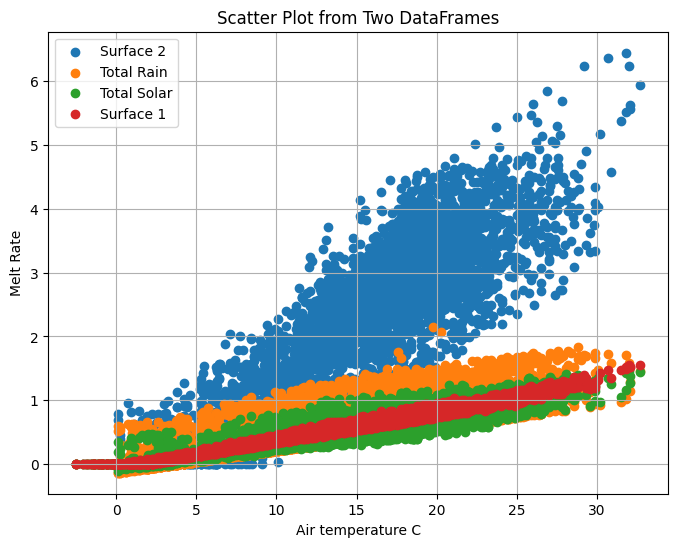

In [84]:
# Generate the scatter plot
plt.figure(figsize=(8, 6))

plt.scatter(df_air_temp, df_SMR_emp2_cond, label='Surface 2')
plt.scatter(df_air_temp, df_SMR_total, label='Total Rain')
plt.scatter(df_air_temp, df_hfmr, label='Total Solar')
plt.scatter(df_air_temp, df_SMR_emp1_cond, label='Surface 1')

plt.title('Scatter Plot from Two DataFrames')
plt.xlabel('Air temperature C')
plt.ylabel('Melt Rate')
plt.legend()
plt.grid()
plt.show()

If this step is not done, the upcoming plot will take a lot of time to render.

With this we convert time from "object" type to "float64", which removes the bottleneck.

In [85]:
# Convert the 'time' column to datetime objects
#df_wo_nan_period_reset['time'] = 

# Convert the datetime objects to Unix timestamps (in seconds) using astype
df_time = pd.to_datetime(df_wo_nan_period_reset['time']).astype('int64') / 1e9

# Display the resulting float64 time column
df_time

0       1.680307e+09
1       1.680311e+09
2       1.680314e+09
3       1.680318e+09
4       1.680322e+09
            ...     
3667    1.693508e+09
3668    1.693512e+09
3669    1.693516e+09
3670    1.693519e+09
3671    1.693523e+09
Name: time, Length: 3672, dtype: float64

In [86]:
df_Tso

0       -3.013333
1       -3.311737
2       -3.593547
3       -3.738275
4       -2.982436
          ...    
3667    12.125750
3668    11.724479
3669    11.426619
3670    11.024568
3671    10.285980
Length: 3672, dtype: float64

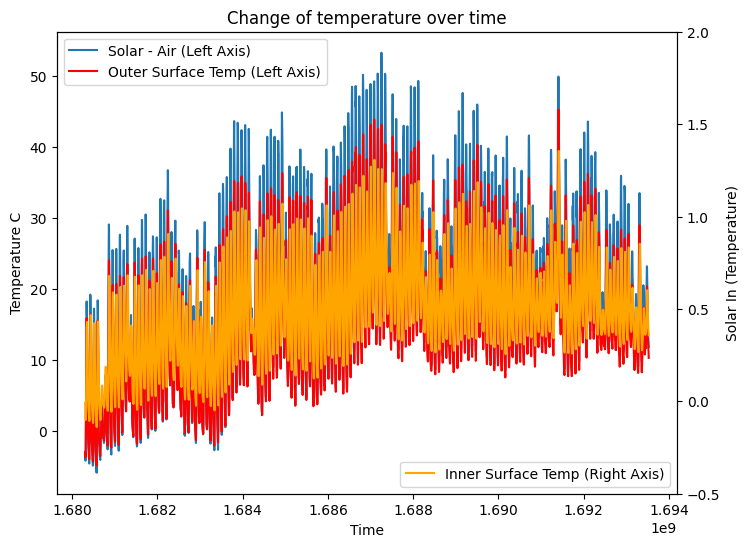

In [87]:
# Generate the scatter plot
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot df_T_sol_air and df_Tso on the primary y-axis
ax1.plot(df_time, df_T_sol_air, label='Solar - Air (Left Axis)')
ax1.plot(df_time, df_Tso, color = 'red', label='Outer Surface Temp (Left Axis)')

ax1.set_xlabel('Time')
ax1.set_ylabel('Temperature C')
ax1.set_title('Change of temperature over time')
ax1.legend(loc='upper left')

# Create a secondary y-axis and plot df_Tsi on it
ax2 = ax1.twinx()
ax2.plot(df_time, df_Tsi, label='Inner Surface Temp (Right Axis)', color='orange')

# Set the y-axis range for the secondary y-axis
#ax2.set_ylim(-0.1, 0.8)
ax2.set_ylim(-0.5, 2.0)
ax2.set_ylabel('Solar In (Temperature)')
ax2.legend(loc='lower right')
plt.show()

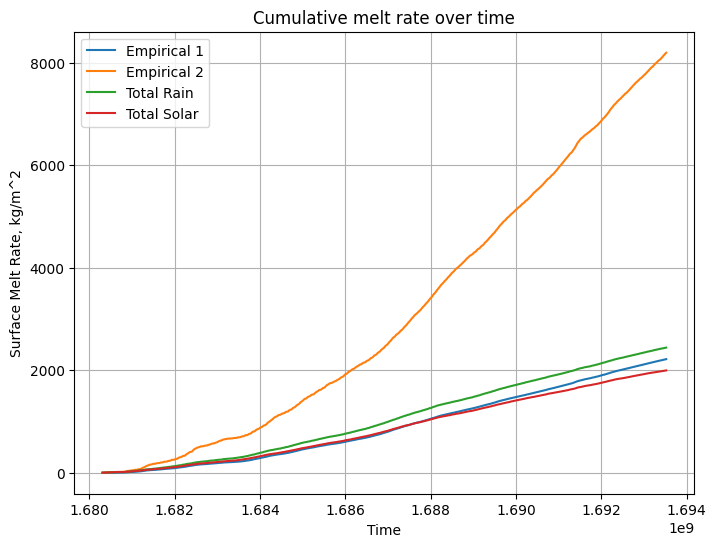

In [88]:
# Generate the scatter plot
plt.figure(figsize=(8, 6))

plt.plot(df_time, df_SMR_emp1_cond_cs, label='Empirical 1')
plt.plot(df_time, df_SMR_emp2_cond_cs, label='Empirical 2')
plt.plot(df_time, df_SMR_total_rain_cs, label='Total Rain')
plt.plot(df_time, df_hfmr_cum, label='Total Solar')

plt.title('Cumulative melt rate over time')
plt.xlabel('Time')
plt.ylabel('Surface Melt Rate, kg/m^2')
plt.legend()
plt.grid()
plt.show()

In [89]:
# Define the time frame
start_time = '2023-06-08T00:00'
end_time = '2023-06-13T00:00'

# Filter the DataFrame
time_mask = (df_wo_nan_period_reset['time'] >= start_time) & (df_wo_nan_period_reset['time'] <= end_time)
filtered_df = df_wo_nan_period_reset['time'].loc[time_mask]

# Get the indices
indices = filtered_df.index

# Display the filtered DataFrame and indices
print(filtered_df)
print(indices)

1632    2023-06-08T00:00
1633    2023-06-08T01:00
1634    2023-06-08T02:00
1635    2023-06-08T03:00
1636    2023-06-08T04:00
              ...       
1748    2023-06-12T20:00
1749    2023-06-12T21:00
1750    2023-06-12T22:00
1751    2023-06-12T23:00
1752    2023-06-13T00:00
Name: time, Length: 121, dtype: object
Index([1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641,
       ...
       1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752],
      dtype='int64', length=121)


In [90]:
df_time.loc[time_mask]

1632    1.686182e+09
1633    1.686186e+09
1634    1.686190e+09
1635    1.686193e+09
1636    1.686197e+09
            ...     
1748    1.686600e+09
1749    1.686604e+09
1750    1.686607e+09
1751    1.686611e+09
1752    1.686614e+09
Name: time, Length: 121, dtype: float64

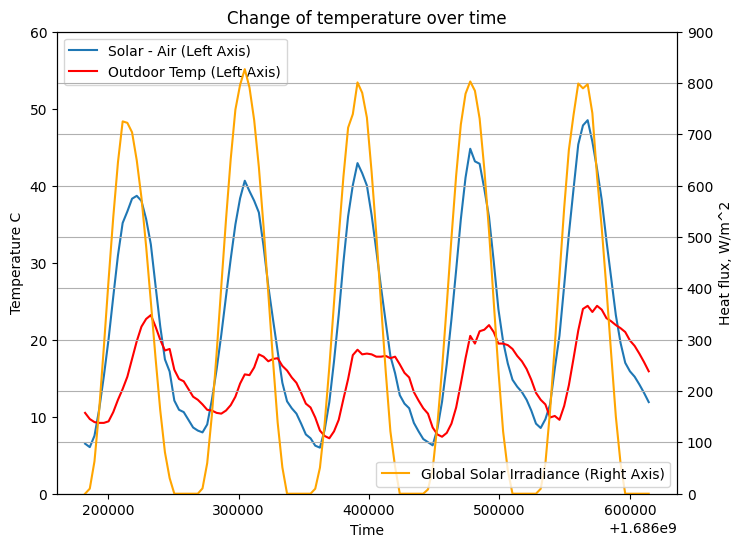

In [91]:
# Generate the scatter plot
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot df_T_sol_air and df_Tso on the primary y-axis
ax1.plot(df_time.loc[time_mask], df_T_sol_air.loc[time_mask], label='Solar - Air (Left Axis)')
ax1.plot(df_time.loc[time_mask], df_air_temp.loc[time_mask], color = 'red', label='Outdoor Temp (Left Axis)')

ax1.set_ylim(0.0, 60)
ax1.set_xlabel('Time')
ax1.set_ylabel('Temperature C')
ax1.set_title('Change of temperature over time')
ax1.legend(loc='upper left')

# Create a secondary y-axis and plot df_Tsi on it
ax2 = ax1.twinx()
ax2.plot(df_time.loc[time_mask], df_Gsi.loc[time_mask], label='Global Solar Irradiance (Right Axis)', color='orange')

# Set the y-axis range for the secondary y-axis
ax2.set_ylim(0.0, 900)
ax2.set_ylabel('Heat flux, W/m^2')
ax2.legend(loc='lower right')
plt.grid()
plt.show()

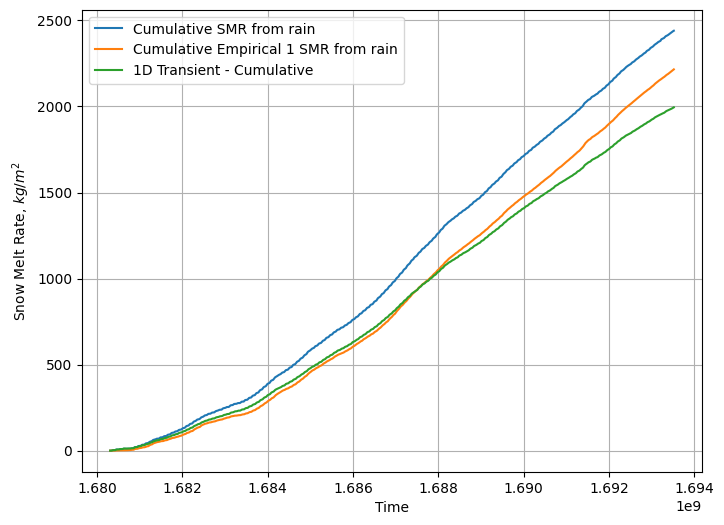

In [92]:
fig, ax = plt.subplots(figsize = (8, 6) )

ax.plot(df_time, df_SMR_total_rain_cs, label='Cumulative SMR from rain')
ax.plot(df_time, df_SMR_emp1_cond_cs, label='Cumulative Empirical 1 SMR from rain')
ax.plot(df_time, df_hfmr_cum, label='1D Transient - Cumulative')

plt.xlabel('Time')
plt.ylabel('Snow Melt Rate, $kg/m^2$')
plt.legend()
plt.grid()

plt.show()

In [ ]:
# Combine into a single DataFrame
combined_df = pd.concat([df_time, df_Tso, df_Tsi], axis=1)

# Export to CSV
combined_df.to_csv('combined_temp_data.csv', index=False)